<a href="https://colab.research.google.com/github/StefanosGZ/Learnpytorch.io/blob/main/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.2.1+cu121


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

1. Image classification
2. Detecting (Videos)
3. Self-driving cars

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting in machine learning occurs when a model learns the training data too well, capturing noise and details to the extent that it negatively impacts the performance on new, unseen data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. Cross-validation: This technique involves dividing the dataset into multiple parts, using some for training and the rest for validation. It helps ensure that the model performs well on unseen data.
2. Regularization: Methods like Ridge and Lasso add a penalty for larger coefficients in the model, which can reduce overfitting by preventing the model from becoming too complex.
3. Early Stopping: This is a form of regularization where you stop training before the model has a chance to overfit. Monitoring the validation loss and stopping when it begins to increase can prevent overfitting.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

Done

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [8]:
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

train_data = MNIST(root = 'data',
                   train = True,
                   download = True,
                   transform = ToTensor(),
                   target_transform = None)
test_data = MNIST(root = 'data',
                  train = False,
                  download = True,
                  transform = ToTensor(),
                  target_transform = False)

train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor()
 Target transform: False)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

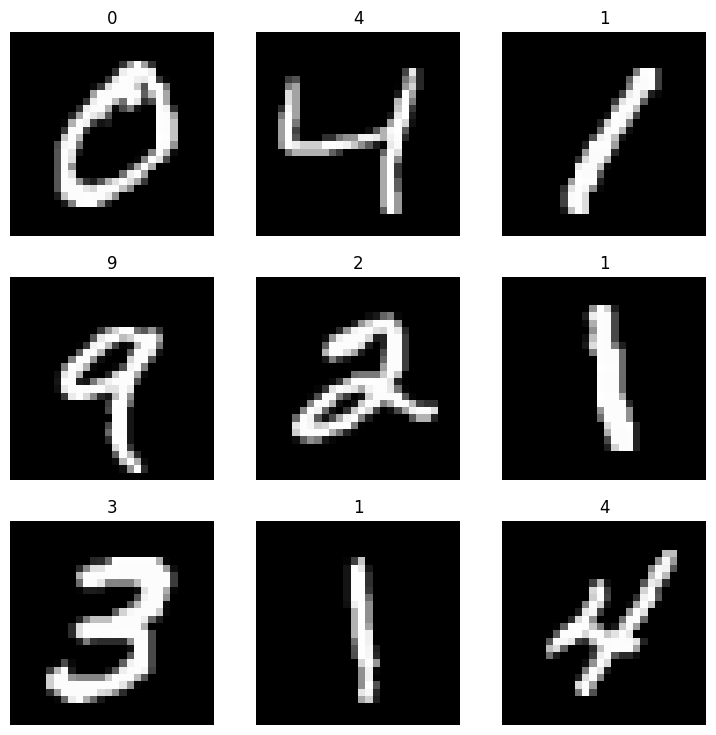

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,9))
rows, cols = 3,3

for i in range(1,rows*cols+1):
  img = train_data[i][0]
  img = img.squeeze()

  label = train_data[i][1]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img, cmap='gray')
  plt.title(label)
  plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True,
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle = False
)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [16]:
from torch import nn
class MNISTV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

model = MNISTV0(input_shape = 1,
                hidden_units = 10,
                output_shape = 10).to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [23]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  model.train()
  train_loss = 0
  model.to(device)
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.3f}")

In [22]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss = 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

    test_loss /= len(data_loader)
    print(f'Test loss: {test_loss:.3f}')

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.1)

In [26]:
epochs = 5
cpu_start = timer()

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n-----')
  train_step(model = model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             device = 'cpu')
  test_step(model = model,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            device = 'cpu')

cpu_end = timer()

print(f"Total training time is: {cpu_end - cpu_start:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0
-----
Train loss: 2.313


TypeError: 'bool' object is not callable

In [ ]:
epochs = 5
cpu_start = timer()

for epoch in tqdm(range(epochs)):
  print(f'Epochs: {epoch}\n-----')
  train_step(model = model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             device = device)
  test_step(model = model,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            device = device)

cpu_end = timer()

print(f"Total training time is: {cpu_end - cpu_start:.2f}")

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?